LSTM that predicts upwards and downwards trend of google stockprice 
Many layers with dropout regularisation to prevent overfitting



# ***Part 1 - Data Preprocessing***

In [1]:
# Importing the libraries
import numpy as np #allow to make arrays
import matplotlib.pyplot as plt #visualize results on charts 
import pandas as pd #import dataset and manage easily

In [2]:
from google.colab import files

uploaded = files.upload()

Saving bitcoin_price_Training - Training.csv to bitcoin_price_Training - Training.csv


In [3]:
# Importing the training set - only importing training set, test set later  on 
#rnn has no idea of the test set's data, then after training is done, test set will eb important
dataset_train = pd.read_csv('bitcoin_price_Training - Training.csv')

#need to make into numpy arrays because only nump arrays can be input values in keras
training_set = dataset_train.iloc[:, 1:2].values 

#getting everything from the columns (.values makes the numpy array)

In [4]:
# Feature Scaling
#2 ways: take obs- min ofstock prices/max of stock prices- min of stock prices
#using normalization instead of standardisation- look at meaning
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set) #fit (gets min and max on data to apply formula) tranform(compute scale stock prices to each formula)

In [6]:
# Creating a data structure with 60 timesteps and 1 output
#60 times steps- at each time t and look at 60 previous time steps, then make new prediction 
# 1 time step leads to overfitting, 20 is still too low
#60 previous financial days- in 3 months 
X_train = []
y_train = []
for i in range(60, 1258): # upper bound is number of values 
  X_train.append(training_set_scaled[i-60:i, 0]) #takes 60 previous stock prices from 60 past stock prices
  y_train.append(training_set_scaled[i, 0]) #contains stock price learned to predict 
X_train, y_train = np.array(X_train), np.array(y_train) # make into numpy arrays 
#Need to add dimension to because not only prescition with one stock price but other indicators (like other columns in dataset  or other stocks that may affect this one )

In [7]:
# Reshaping- add dimension in numpy array 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #adds dimension in numpy array
#currently only have one indicator, with new dimension will have more indicators, be compatible for "input shape" of RNN
# format according to keras documentation 


Part 2 - Building the RNN 
stacked lstm with dropout regularization to prevent overfitting

In [8]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [9]:
# Initialising the RNN
regressor = Sequential() #reps sequence of layers, predicting continous values (so it is a regression)

In [10]:
# Adding the first LSTM layer and some Dropout regularisation
#dropout to prevent overfitting
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))#regressor- object of sequential class, can add layers to networ.
#use lstm class and create object of lstm class- 3 args
#num of units, return sequences- set to true because is stacked lstms, and shape
#units- neurons in first layer. 50 in layers for high dimensionality, can capture upward and downward
regressor.add(Dropout(0.2))
# takes arg of dropout late- num of neurons want to drop. dropping 20% of neurons to be ignored during trianingn for each iteratin. 10 neurons will be dropped out

In [11]:
# Adding a second LSTM layer and some Dropout regularisation
# total of 4 layers, simply need to copy, only change is input shape so dont need to specify that, automatically recognised through input shape

regressor.add(LSTM(units = 50, return_sequences = True)) 

regressor.add(Dropout(0.2))

In [12]:
# Adding a third LSTM layer and some Dropout regularisation
# same as second layer 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [13]:
# Adding a fourth LSTM layer and some Dropout regularisation
# almost same, but return sequence is false because it is the last lstm layer (so it is removed becasue default is false)
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [14]:
# Adding the output layer
#add fully connected layer through dense class- dimesion/units/neurons is 1
regressor.add(Dense(units = 1))

In [15]:
# Compiling the RNN
#regressior because predicting continuous value, 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
# Fitting the RNN to the Training set
#have not made connection to training set, training will take place
regressor.fit(X_train, y_train, epochs = 200, batch_size = 32) # CHANGE BACK TO 100 IF NOT WORK
#100 gives good convergence
# trained on certain batch sizes, 

Epoch 1/200
38/38 [==============================] - 10s 16ms/step - loss: 0.0051
Epoch 2/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0011
Epoch 3/200
38/38 [==============================] - 1s 13ms/step - loss: 9.1756e-04
Epoch 4/200
38/38 [==============================] - 1s 14ms/step - loss: 9.8849e-04
Epoch 5/200
38/38 [==============================] - 1s 13ms/step - loss: 8.1511e-04
Epoch 6/200
38/38 [==============================] - 1s 13ms/step - loss: 8.8836e-04
Epoch 7/200
38/38 [==============================] - 1s 13ms/step - loss: 8.9992e-04
Epoch 8/200
38/38 [==============================] - 1s 13ms/step - loss: 7.3828e-04
Epoch 9/200
38/38 [==============================] - 1s 14ms/step - loss: 6.9715e-04
Epoch 10/200
38/38 [==============================] - 1s 15ms/step - loss: 6.8674e-04
Epoch 11/200
38/38 [==============================] - 1s 15ms/step - loss: 7.3298e-04
Epoch 12/200
38/38 [==============================] - 1s 14ms/step - l

Part 3 - Making the predictions and visualising the results

In [17]:
from google.colab import files

uploaded = files.upload()

Saving bitcoin_price_1week_Test - Test.csv to bitcoin_price_1week_Test - Test.csv


In [19]:
# Getting the real stock price of 2018
dataset_test = pd.read_csv('bitcoin_price_1week_Test - Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [21]:
real_stock_price.shape

(7, 1)

In [24]:
# Getting the predicted stock price of 2018
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values #getting input of each previous financial days
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 66):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


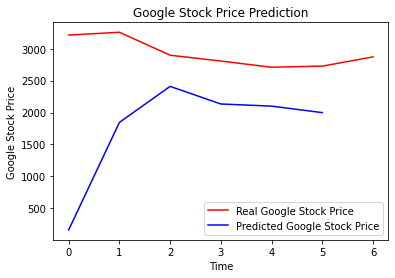

In [25]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# **Practicing on pediction of sin data**

In [89]:
# Importing the libraries
import numpy as np #allow to make arrays
import matplotlib.pyplot as plt #visualize results on charts 
import pandas as pd #import dataset and manage easily

In [119]:
from google.colab import files

uploaded = files.upload()

Saving sin func test.csv to sin func test.csv
Saving sin fun train.csv to sin fun train.csv


In [120]:
# Importing the training set - only importing training set, test set later  on 
#rnn has no idea of the test set's data, then after training is done, test set will eb important
dataset_train = pd.read_csv('sin fun train.csv')

#need to make into numpy arrays because only nump arrays can be input values in keras
training_set = dataset_train.iloc[:, 1:2].values 

#getting everything from the columns (.values makes the numpy array)

In [121]:
# Feature Scaling
#2 ways: take obs- min ofstock prices/max of stock prices- min of stock prices
#using normalization instead of standardisation- look at meaning
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set) #fit (gets min and max on data to apply formula) tranform(compute scale stock prices to each formula)

In [122]:
# Creating a data structure with 60 timesteps and 1 output
#60 times steps- at each time t and look at 60 previous time steps, then make new prediction 
# 1 time step leads to overfitting, 20 is still too low
#60 previous financial days- in 3 months 
X_train = []
y_train = []
for i in range(60, 1258): # upper bound is number of values 
  X_train.append(training_set_scaled[i-60:i, 0]) #takes 60 previous stock prices from 60 past stock prices
  y_train.append(training_set_scaled[i, 0]) #contains stock price learned to predict 
X_train, y_train = np.array(X_train), np.array(y_train) # make into numpy arrays 
#Need to add dimension to because not only prescition with one stock price but other indicators (like other columns in dataset  or other stocks that may affect this one )

In [123]:
# Reshaping- add dimension in numpy array 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #adds dimension in numpy array
#currently only have one indicator, with new dimension will have more indicators, be compatible for "input shape" of RNN
# format according to keras documentation 


In [124]:
# Getting the real stock price of 2018
dataset_test = pd.read_csv('sin func test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [125]:
# Getting the predicted stock price of 2018
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values #getting input of each previous financial days
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 79):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

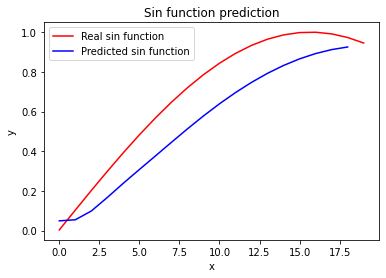

In [127]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real sin function')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted sin function')
plt.title('Sin function prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [130]:
dataset_test

,Date,Open,High,Low,Close,Volume,Unnamed: 6,Unnamed: 7
0,1/3/2017,0.003629,789.63,775.80,786.14,"1,657,300",12.57,0.003629
1,1/4/2017,0.103444,791.34,783.16,786.90,"1,073,000",12.67,0.103444
2,1/5/2017,0.202225,794.48,785.02,794.02,"1,335,200",12.77,0.202225
3,1/6/2017,0.298986,807.90,792.20,806.15,"1,640,200",12.87,0.298986
4,1/9/2017,0.392759,809.97,802.83,806.65,"1,272,400",12.97,0.392759
5,1/10/2017,0.482607,809.13,803.51,804.79,"1,176,800",13.07,0.482607
6,1/11/2017,0.567634,808.15,801.37,807.91,"1,065,900",13.17,0.567634
7,1/12/2017,0.646989,807.39,799.17,806.36,"1,353,100",13.27,0.646989
8,1/13/2017,0.719880,811.22,806.69,807.88,"1,099,200",13.37,0.719880
9,1/17/2017,0.785578,807.14,800.37,804.61,"1,362,100",13.47,0.785578


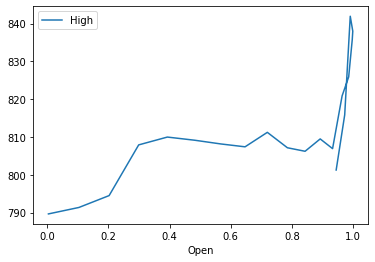

In [133]:
dataset_test.plot(x='Open', y='High')


In [135]:
x=dataset_test['Open']
y=dataset_test['High']
y=y.to_numpy()

# **Moving average**

In [136]:
arr = x
window_size = 3
  
i = 0
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(arr) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = arr[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1
  
print(moving_averages)

[0.1, 0.2, 0.3, 0.39, 0.48, 0.57, 0.64, 0.72, 0.78, 0.84, 0.89, 0.93, 0.96, 0.98, 0.99, 1.0, 0.99, 0.97]


In [140]:
moving_averages = np.array(moving_averages)
moving_averages.shape

In [153]:
y=y[0:18]

# **Sketching data versus moving average**





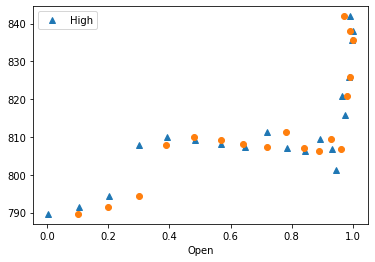

In [159]:
dataset_test.plot(x='Open', y='High',marker='^', linestyle = 'None')

plt.plot(moving_averages, y, marker='o', linestyle = 'None')

# **Getting moving average of Google stock prices contained in train dataset**

In [164]:
# Importing the training set - only importing training set, test set later  on 
#rnn has no idea of the test set's data, then after training is done, test set will eb important
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [163]:
x=dataset_train['Open']
y=dataset_train['High']
y=y.to_numpy()

In [165]:
arr = x
window_size = 3
  
i = 0
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(arr) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = arr[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1
  
print(moving_averages)

[328.78, 329.81, 326.74, 321.36, 315.44, 312.91, 312.33, 313.73, 312.97, 315.42, 308.53, 301.79, 292.71, 290.55, 288.22, 285.64, 285.73, 287.56, 289.91, 291.04, 292.32, 293.99, 297.69, 300.67, 303.5, 303.62, 303.93, 303.85, 304.69, 303.41, 302.32, 300.82, 302.34, 302.67, 303.25, 302.36, 302.85, 304.72, 307.32, 309.32, 309.62, 307.26, 305.11, 303.39, 303.37, 301.87, 301.65, 302.82, 305.58, 307.6, 308.95, 311.32, 313.6, 316.15, 318.76, 320.48, 321.9, 322.8, 324.2, 324.99, 323.12, 321.78, 319.57, 318.16, 315.35, 314.53, 314.82, 317.12, 319.45, 317.63, 312.02, 305.46, 302.58, 301.87, 299.35, 298.11, 298.07, 301.06, 303.85, 305.34, 304.16, 301.87, 301.31, 301.66, 300.63, 299.95, 300.1, 303.08, 303.89, 302.88, 301.62, 302.88, 308.37, 311.65, 308.75, 305.36, 301.47, 302.9, 300.84, 299.87, 296.38, 294.34, 290.36, 287.38, 285.18, 285.95, 288.84, 288.9, 290.19, 287.23, 284.88, 281.08, 279.51, 279.66, 281.7, 284.93, 287.79, 286.87, 284.8, 281.96, 281.91, 281.67, 283.7, 286.04, 288.38, 290.67, 292

In [166]:
moving_averages = np.array(moving_averages)
moving_averages.shape

(1256,)

In [168]:
y=y[0:len(y)-2]

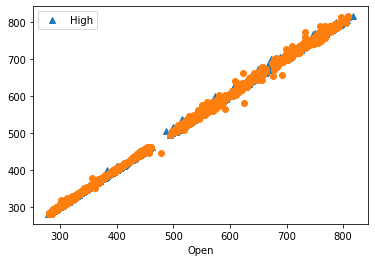

In [169]:
dataset_train.plot(x='Open', y='High',marker='^', linestyle = 'None')

plt.plot(moving_averages, y, marker='o', linestyle = 'None')

In [174]:
date=dataset_train['Date']

In [180]:
from datetime import datetime
date_format = "%m/%d/%Y"
a = datetime.strptime('1/3/2012', date_format)

kP=[]

for i in range(len(date)):
    b = datetime.strptime(date[i], date_format)
    diff = b - a
    kP.append(diff.days)
    


In [205]:
y=dataset_train['Open']
x=kP
s=kP

In [190]:
s=s[0:len(s)-2]

# **Moving average versus actual data**

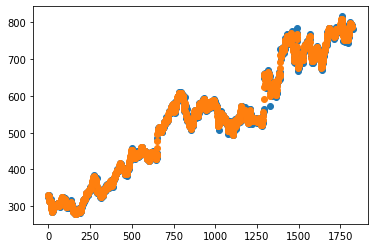

In [191]:
plt.plot(x, y, marker='o', linestyle = 'None')
plt.plot(s, moving_averages, marker='o', linestyle = 'None')

# **Now tweaking window size from 3 to 10**





In [192]:
arr = y
window_size = 10
  
i = 0
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(arr) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = arr[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1
  
print(moving_averages)

[320.22, 318.91, 317.71, 314.15, 310.5, 307.51, 304.9, 302.34, 299.33, 296.93, 294.49, 292.41, 289.61, 289.62, 290.07, 291.11, 292.66, 294.65, 296.5, 298.12, 299.54, 300.93, 301.83, 302.54, 302.98, 303.22, 303.14, 302.91, 302.84, 302.82, 303.17, 303.63, 304.59, 305.36, 305.57, 305.42, 305.57, 305.6, 305.27, 305.21, 305.03, 304.75, 304.7, 304.83, 305.97, 307.24, 308.66, 310.59, 312.83, 314.74, 316.58, 318.42, 319.95, 320.83, 321.55, 321.74, 321.43, 320.53, 319.96, 319.31, 318.83, 318.53, 317.1, 315.5, 313.63, 312.0, 310.61, 308.83, 307.08, 305.58, 304.02, 302.4, 301.9, 301.66, 301.32, 301.51, 301.6, 301.7, 302.07, 302.21, 302.31, 302.08, 301.47, 301.55, 302.38, 303.59, 304.54, 304.82, 305.21, 304.95, 304.76, 304.3, 304.05, 303.19, 301.74, 298.65, 295.91, 294.67, 292.82, 292.12, 290.46, 289.63, 288.33, 287.01, 285.65, 285.08, 284.7, 284.61, 284.77, 284.39, 283.99, 283.15, 282.8, 283.1, 283.33, 284.06, 285.02, 285.34, 285.78, 286.41, 287.25, 288.39, 289.07, 289.04, 289.35, 289.42, 289.25,

In [193]:
moving_averages = np.array(moving_averages)
moving_averages.shape

(1249,)

In [200]:
s=s[0:len(s)-9]

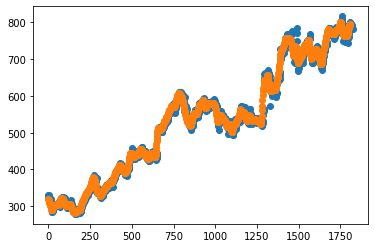

In [201]:
plt.plot(x, y, marker='o', linestyle = 'None')
plt.plot(s, moving_averages, marker='o', linestyle = 'None')

# **Now tweaking window size from 3 to 30**

In [202]:
arr = y
window_size = 30
  
i = 0
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(arr) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = arr[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1
  
print(moving_averages)

moving_averages = np.array(moving_averages)
moving_averages.shape

[304.75, 304.08, 303.05, 302.1, 301.18, 300.61, 300.23, 299.97, 299.56, 299.29, 299.06, 298.99, 298.68, 299.17, 299.54, 299.92, 300.46, 301.05, 301.54, 302.05, 302.58, 303.11, 303.7, 304.24, 304.84, 305.3, 305.79, 306.37, 306.98, 307.59, 308.26, 308.93, 309.75, 310.34, 311.03, 311.47, 311.89, 312.24, 312.69, 313.08, 313.48, 313.9, 313.92, 313.72, 313.72, 313.66, 313.57, 313.32, 313.29, 313.21, 313.14, 313.11, 312.98, 312.66, 312.17, 311.75, 311.21, 310.36, 309.7, 309.03, 308.38, 307.67, 306.82, 306.23, 305.78, 305.7, 305.58, 305.12, 304.78, 304.25, 303.7, 302.92, 302.47, 302.13, 301.81, 301.25, 300.68, 300.39, 300.03, 299.76, 299.18, 298.67, 297.95, 297.25, 296.59, 295.77, 295.05, 294.7, 294.27, 293.82, 293.07, 292.36, 291.73, 291.1, 290.24, 289.26, 288.54, 288.2, 287.79, 287.64, 287.24, 287.06, 286.73, 286.38, 286.11, 286.19, 286.32, 286.35, 286.51, 286.86, 287.27, 287.78, 288.42, 289.3, 290.26, 291.52, 292.61, 293.67, 294.43, 295.42, 296.61, 297.85, 299.12, 300.39, 301.6, 302.8, 304.

(1229,)

In [206]:
s=s[0:len(s)-29]

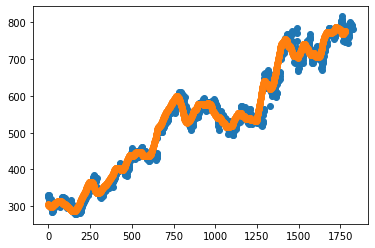

In [207]:
plt.plot(x, y, marker='o', linestyle = 'None')
plt.plot(s, moving_averages, marker='o', linestyle = 'None')